In [66]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from glob import glob
import os
import scipy.io
from sklearn.linear_model import LogisticRegression
from scipy.signal import spectrogram


In [112]:
CWRU_X_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/0.npz")["x"]
CWRU_y_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/0.npz")["y"]
CWRU_X_1 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/1.npz")["x"]
CWRU_y_1 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/1.npz")["y"]
#CWRU_X_2 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/2.npz")["x"]
#CWRU_X_3 = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/3.npz")["x"]
CWRU_X_all = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/all.npz")["x"]
CWRU_y_all = np.load("/data/home/jkataok1/DA_DFD/data/processed/CWRU/all.npz")["y"]
IMS_X_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/IMS/0.npz")["x"]
IMS_y_0 = np.load("/data/home/jkataok1/DA_DFD/data/processed/IMS/0.npz")["y"]

In [105]:

def normalize_signal(df):
    mean = df['DE_time'].apply(np.mean)
    std = df['DE_time'].apply(np.std)
    df['DE_time'] = (df['DE_time'] - mean) / std
    return mean, std

def divide_signal(df, segment_length):

    dic = {}
    idx = 0
    for i in range(df.shape[0]): # 파일 개수
        n_sample_points = len(df.iloc[i,1]) # 파일 안에 있는 신호 개수 # 예를들어 122571
        n_segments = n_sample_points // segment_length # 원하는 segment 길이만큼 슬라이싱 할 개수 # 예를 들어 segment_length는 500, n_segments는 245
        for segment in range(n_segments): 
            dic[idx] = { # 
                'signal': df.iloc[i,1][segment_length * segment:segment_length * (segment+1)], 
                'label': df.iloc[i,2],
                'filename' : df.iloc[i,0]
            }
            idx += 1
    df_tmp = pd.DataFrame.from_dict(dic,orient='index')
    df_output = pd.concat(
        [df_tmp[['label', 'filename']], 
         pd.DataFrame(np.hstack(df_tmp["signal"].values).T)
        ], 
        axis=1 )
    return df_output

def get_df_all(df, segment_length=512, normalize=False):

    if normalize:
        mean, std = normalize_signal(df)
    else:
        mean, std = 0.0, 1.0

    df_processed = divide_signal(df, segment_length)

    map_label = {'N':0, 'B':1, 'IR':2, 'OR':3}
    df_processed['label'] = df_processed['label'].map(map_label)
    return df_processed, mean, std

def matfile_to_dic(folder_path):
    '''
    Read all the matlab files of the CWRU Bearing Dataset and return a 
    dictionary. The key of each item is the filename and the value is the data 
    of one matlab file, which also has key value pairs.
    
    Parameter:
        folder_path: 
            Path (Path object) of the folder which contains the matlab files.
    Return:
        output_dic: 
            Dictionary which contains data of all files in the folder_path.
    '''
    output_dic = {}
    for _, filepath in enumerate(glob(os.path.join(folder_path, '*.mat'))):
        # strip the folder path and get the filename only.
        key_name = str(filepath).split('\\')[-1]
        output_dic[key_name] = scipy.io.loadmat(filepath)
    return output_dic

def remove_dic_items(dic):
    '''
    Remove redundant data in the dictionary returned by matfile_to_dic inplace.
    '''
    # For each file in the dictionary, delete the redundant key-value pairs
    for _, values in dic.items():
        del values['__header__']
        del values['__version__']    
        del values['__globals__']

def rename_keys(dic):
    '''
    Rename some keys so that they can be loaded into a 
    DataFrame with consistent column names
    '''
    # For each file in the dictionary
    for _,v1 in dic.items():
        # For each key-value pair, rename the following keys 
        for k2,_ in list(v1.items()):
            if 'DE_time' in k2:
                v1['DE_time'] = v1.pop(k2)
            elif 'BA_time' in k2:
                v1['BA_time'] = v1.pop(k2)
            elif 'FE_time' in k2:
                v1['FE_time'] = v1.pop(k2)
            elif 'RPM' in k2:
                v1['RPM'] = v1.pop(k2)

def label(filename):
    '''
    Function to create label for each signal based on the filename. Apply this
    to the "filename" column of the DataFrame.
    Usage:
        df['label'] = df['filename'].apply(label)
    '''
    if 'B' in filename:
        return 'B'
    elif 'IR' in filename:
        return 'IR'
    elif 'OR' in filename:
        return 'OR'
    elif 'Normal' in filename:
        return 'N'

def matfile_to_df(folder_path):
    '''
    Read all the matlab files in the folder, preprocess, and return a DataFrame
    
    Parameter:
        folder_path: 
            Path (Path object) of the folder which contains the matlab files.
    Return:
        DataFrame with preprocessed data
    '''
    dic = matfile_to_dic(folder_path)
    remove_dic_items(dic)
    rename_keys(dic)
    df = pd.DataFrame.from_dict(dic).T
    df = df.reset_index().rename(mapper={'index':'filename'},axis=1)
    df['label'] = df['filename'].apply(label)
    return df.drop(['BA_time','FE_time', 'RPM', 'ans'], axis=1, errors='ignore')

def create_dataset_cwru(datapath_list, segment_length=2048, normalize=True):
    res = []
    for df in datapath_list:
        df_temp = matfile_to_df(df)
        res.append(df_temp)
    df = pd.concat(res, axis=0)
    df_all, mean, std = get_df_all(df, segment_length, normalize)
    return df_all

[ 1.48626969 -1.20316894 -5.89683044 ...  0.92994347 -3.84286107
  0.51588891]


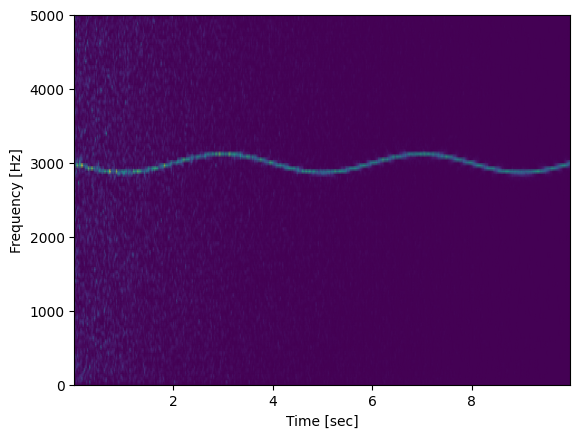

In [71]:
rng = np.random.default_rng()
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise
print(x)

f, t, Sxx = spectrogram(x, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [123]:
datapath_fe12 = "/data/home/jkataok1/DA_DFD/data/raw/CWRU/12k_FE"
datapath_de12 = "/data/home/jkataok1/DA_DFD/data/raw/CWRU/12k_DE"
datapath_nor = "/data/home/jkataok1/DA_DFD/data/raw/CWRU/Normal"
datapath_list = [datapath_de12, datapath_de12, datapath_nor]
df12 = create_dataset_cwru(datapath_list, 2048, False)

def generate_spectrogram(df, fs=12000, nperseg=128):
    res_x = []
    for i in range(len(df)):
        x = df.loc[i, ~df.columns.isin(['label', "filename"])].to_list()
        f, t, Sxx = spectrogram(np.array(x), fs=fs, nperseg=nperseg)
        res_x.append(Sxx)
    res_x = np.stack(res_x)
    res_x_norm = (res_x - res_x.mean(axis=(0, 2), keepdims=True)) / (res_x.std(axis=(0, 2), keepdims=True)+1e-8)
    return res_x_norm
    

x12 = generate_spectrogram(df12, fs=1200, nperseg=128)

array([[[-5.72981806e-06,  9.21605493e-05,  5.63423443e-07, ...,
          2.05042494e-05,  5.23679577e-05,  3.39777518e-05],
        [-7.41394122e-06, -1.14900150e-05,  6.91867907e-06, ...,
         -1.32456956e-05, -1.11284891e-05,  7.40872431e-06],
        [ 2.81585951e-06,  3.98465617e-05, -5.78792397e-06, ...,
          5.85875546e-05,  1.11995989e-05,  3.76264716e-06],
        ...,
        [-1.73925591e-08,  6.04926124e-07,  6.70005807e-07, ...,
          4.47902319e-07,  1.93344372e-07,  2.62320518e-07],
        [-2.00954489e-08,  1.65670301e-07,  3.16980690e-07, ...,
          4.02012593e-07,  3.16064491e-07,  1.34859921e-08],
        [-6.61782144e-09,  4.84695216e-08,  1.02012388e-07, ...,
          1.86252501e-07,  1.76434793e-07,  1.36722124e-08]],

       [[ 2.24770295e-05,  1.00134984e-04,  4.88618888e-06, ...,
         -6.01509847e-06, -4.45543587e-06, -4.10711009e-06],
        [-1.39744476e-05, -7.00812162e-06, -1.22578736e-05, ...,
         -1.34985459e-05, -3.78003875e

In [116]:
datapath_de48 = "/data/home/jkataok1/DA_DFD/data/raw/CWRU/48k_DE"

#df48 = create_dataset_cwru([datapath_de48], 2048, False)
#df48
#x48, y48 = generate_spectrogram(df48, fs=48000, nperseg=128)

TypeError: unhashable type: 'numpy.ndarray'

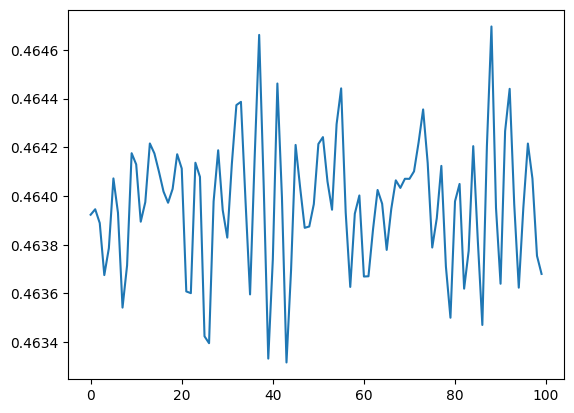

In [116]:
# Generate random index
ims = IMS_X_0[:, 0, :]
cwru = CWRU_X_all[:, 0, :]
y_cwru = CWRU_y_all[:]

y_ims = IMS_y_0[:]
#y_ims[y_ims == 2] = 1
#y_ims[y_ims != 2] = 0
#model.fit(ims, y_ims.reshape(-1))
#model.score(cwru, y_cwru.reshape(-1))

#plt.boxplot(ims[(y_ims == 0).reshape(-1), :].mean(axis=1))
#plt.boxplot(ims[(y_ims == 1).reshape(-1), :].mean(axis=1))
#plt.boxplot(ims[(y_ims == 2).reshape(-1), :].mean(axis=1))
#plt.boxplot(ims[(y_ims == 3).reshape(-1), :].mean(axis=1)
cs = CubicSpline(np.arange(0, 2048), ims.mean(axis=0).reshape(-1))
xs = np.arange(0, 2048, 1)
cs_xs = cs(xs)
#plt.plot(cs_xs[:100])
plt.plot(cwru.mean(axis=0)[:100])


#y_cwru[y_cwru == 2] = 1
#y_cwru[y_cwru != 2] = 0



In [32]:
cs = CubicSpline(np.arange(0, 2048), ims)
xs = np.arange(0, 2048, 0.1)
cs_xs = cs(xs)

NameError: name 'xs' is not defined

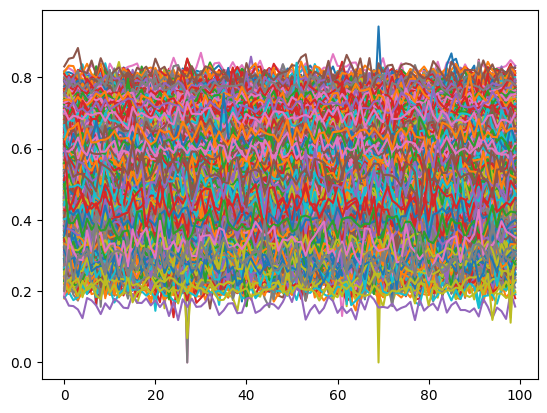

In [64]:

plt.plot(ims[:100], label="cubic spline")
plt.plot(xs[:1000], cs_xs[:1000], label="cubic spline")